In [9]:
import numpy as np
from matplotlib import pyplot as plt
from echospec.utils.parameters import Parameters
from echospec.experiments.spectroscopy_vs_amplitude import AmplitudeSweepSpectroscopy, OptionsSpectroscopy2d
from echospec.utils.units import Units as u

Amplitude sweep:   0%|          | 0/21 [00:00<?, ?Ω/s]

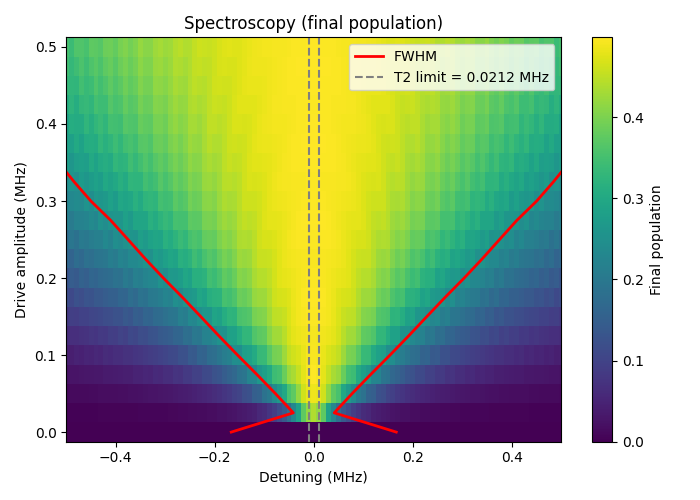

In [13]:
options = OptionsSpectroscopy2d(plot=True)
options.num_time_points = 5000
params = Parameters()
params.eco_pulse = True
params.pulse_length = 100*u.us
params.cutoff = 0.999
# params.detuning = 0.1*u.MHz*2*np.pi


detunings = np.linspace(-0.5, 0.5, 101)*2*np.pi*u.MHz
amplitudes = np.linspace(0, 0.50, 21)*2*np.pi*u.MHz
spectroscopy = AmplitudeSweepSpectroscopy(
    amplitudes=amplitudes,
    detunings=detunings,
    params=params,
    options=options
)

results = spectroscopy.run()

In [11]:
ts = results.spectroscopies[0].time  # in us
detunings = results.detunings
amplitudes = results.amplitudes
final_z= results.final_map()

interactive(children=(IntSlider(value=0, description='Detuning'), IntSlider(value=0, description='Amplitude', …

<function __main__.update(detuning_index, amplitude_index) -> None>

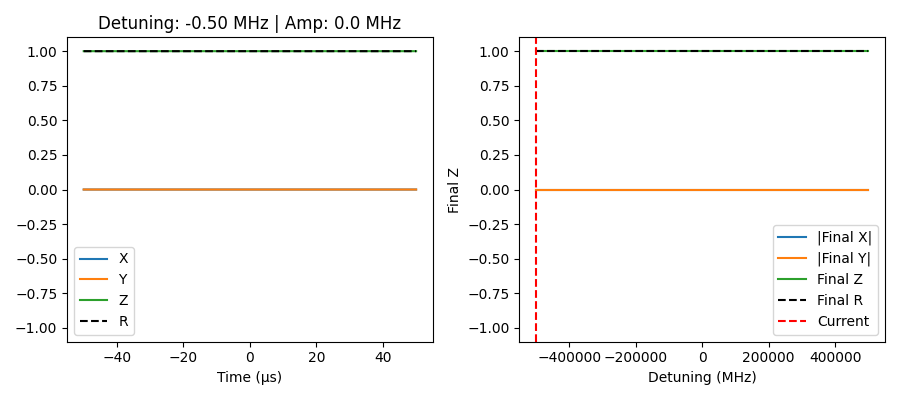

In [12]:
%matplotlib ipympl
from ipywidgets import interact, IntSlider

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

det_idx0 = 0
amp_idx0 = 0

raw_data = results.raw_data()

x0 = raw_data[:,0,:,:][det_idx0][amp_idx0]
y0 = raw_data[:,1,:,:][det_idx0][amp_idx0]
z0 = raw_data[:,2,:,:][det_idx0][amp_idx0]


r0 = np.sqrt(x0**2 + y0**2 + z0**2)

ax = axs[0]
(line_x,) = ax.plot(ts * 1e6, x0, label="X")
(line_y,) = ax.plot(ts * 1e6, y0, label="Y")
(line_z,) = ax.plot(ts * 1e6, z0, label="Z")
(line_r,) = ax.plot(ts * 1e6, r0, "--", color="black", label="R")

ax.set_xlabel("Time (µs)")
ax.legend()
ax.set_ylim(-1.1, 1.1)
title = ax.set_title(f"Detuning: {detunings[det_idx0]:.2f} MHz | Amp: {amplitudes[amp_idx0]:.1f} MHz")

# final Z at end of pulse
final_x = results.final_map(observable="x")
final_y = results.final_map(observable="y")
final_z = results.final_map()

final_r = np.sqrt(final_x**2 + final_y**2 + final_z**2)

ax2 = axs[1]
(spec_line_x,) = ax2.plot(detunings/2/np.pi, np.abs(final_x[amp_idx0]), label="|Final X|")
(spec_line_y,) = ax2.plot(detunings/2/np.pi, np.abs(final_y[amp_idx0]), label="|Final Y|")
(spec_line_z,) = ax2.plot(detunings/2/np.pi, final_z[amp_idx0], label="Final Z")
(spec_line_r,) = ax2.plot(detunings/2/np.pi, final_r[amp_idx0], "--", color="black", label="Final R")

vline = ax2.axvline(detunings[det_idx0]/2/np.pi, color="red", linestyle="--", label="Current")
ax2.set_xlabel("Detuning (MHz)")
ax2.set_ylabel("Final Z")
ax2.legend()
ax2.set_ylim(-1.1, 1.1)

fig.tight_layout()
fig.canvas.draw_idle()

def update(detuning_index, amplitude_index) -> None:
    x = raw_data[:,0,:,:][amplitude_index][detuning_index]
    y = raw_data[:,1,:,:][amplitude_index][detuning_index]
    z = raw_data[:,2,:,:][amplitude_index][detuning_index]
    
    r = np.sqrt(x**2 + y**2 + z**2)

    line_x.set_ydata(x)
    line_y.set_ydata(y)
    line_z.set_ydata(z)
    line_r.set_ydata(r)

    title.set_text(
        f"Detuning: {detunings[detuning_index]/1e6/2/np.pi:.2f} MHz | Amp: {amplitudes[amplitude_index]:.1f} MHz"
    )

    spec_line_x.set_ydata(final_x[amplitude_index])
    spec_line_y.set_ydata(final_y[amplitude_index])
    spec_line_z.set_ydata(final_z[amplitude_index])
    spec_line_r.set_ydata(final_r[amplitude_index])
    vline.set_xdata([detunings[detuning_index]/2/np.pi])

    # fig.canvas.draw_idle()

interact(
    update,
    detuning_index=IntSlider(min=0, max=len(detunings) - 1, step=1, value=det_idx0, description="Detuning"),
    amplitude_index=IntSlider(min=0, max=len(amplitudes) - 1, step=1, value=amp_idx0, description="Amplitude"),
)
